<h1 style="text-align: center;">
    🌌 Creating Data Streams
</h1>

This notebook demonstrates how to create evolving distributions with `streamgen` using parameter schedules.

---

## 📄 Table of Contents

1. [🌳 Sampling tree](#🌳-sampling-tree)
2. [⚙️ Parameter schedules](#⚙️-parameter-schedules)
3. [🫂 Putting everything together](#🫂-putting-everything-together)


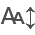

In [1]:
import itables
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML
from IPython.utils import io
from matplotlib.animation import FuncAnimation

from streamgen.parameter.store import ParameterStore
from streamgen.samplers.tree import SamplingTree

SEED=42
rng = np.random.default_rng(SEED)

itables.init_notebook_mode(all_interactive=False)

## 🌳 Sampling tree

We will re-use our time-series example from [examples/time series classification/01_static_distributions.ipynb](./01_static_distributions.ipynb):

In [2]:
# ➡️ transforms and generators
def background(signal_, signal_length: int, offset: float, strength: float) -> np.ndarray:  # noqa: D103, ANN001, ARG001
    return rng.normal(offset, strength, signal_length)

def ramp(signal: np.ndarray, height: float, length: int) -> np.ndarray:  # noqa: D103
    ramp_signal = np.zeros(len(signal))
    ramp_start = rng.choice(range(len(signal)-length))
    ramp_signal[ramp_start:ramp_start+length] = np.linspace(0.0, height, length)
    return signal + ramp_signal

def step(signal: np.ndarray, length: int, kernel_size: int) -> np.ndarray:  # noqa: D103
    step_signal = np.zeros(len(signal))
    step_start = rng.choice(range(len(signal)-length))
    step_signal[step_start:step_start+length] = 1.0
    kernel = np.ones(kernel_size) / kernel_size
    step_signal = np.convolve(step_signal, kernel, mode="same")
    return signal + step_signal

# ⚙️ scoped parameter
params = ParameterStore({
    "background": {
        "signal_length": { "value": 256 },
        "offset": { "value": 0.0 },
        "strength": { "value": 0.1 },
    },
    "ramp": {
        "height": { "value": 1.0 },
        "length": { "value": 128 },
    },
    "step": {
        "length": { "value": 128 },
        "kernel_size": { "value": 10 },
    },
})

# 🎲🌳 tree of transformations
tree = SamplingTree(
    [
        background,
        {
            "background": "background",
            "ramp": [ramp, "ramp"],
            "step": [step, "step"],
        },
    ],
    params,
)

print(tree)

🌳
➡️ `background(offset=0.0, signal_length=256, strength=0.1)`
╰── 🪴 `branching point()`
    ├── 🏷️ `background`
    ├── ➡️ `ramp(height=1.0, length=128)`
    │   ╰── 🏷️ `ramp`
    ╰── ➡️ `step(kernel_size=10, length=128)`
        ╰── 🏷️ `step`



## ⚙️ Parameter schedules

The tree we defined currently represents a static distribution, since the parameters that influence **how** the signals are constructed don't change over time.

If we want to model evolving distributions, we either need to change the **parameters** or **topology** of the tree over time. In this notebook, we will focus on scheduling the parameters.

![parameter schedule](../../docs/images/parameter_schedule.png)

`streamgen` has its own `Parameter` class, which represents a named variable that can change over time as defined by its **schedule**.

A `schedule` of a variable is simply an `Iterable` of values.
Additionally, you can define what happens when a schedule is exhausted via a parameters `strategy`.

Lets create schedules for our example parameters:

In [3]:
params = ParameterStore({
    "background": {
        "signal_length": { "value": 256 }, # parameters don't need to have a schedule
        "offset": { "schedule": [0.0, 0.2, 0.5] }, # if only a schedule is defined, the first element will be used as the value
        "strength": {
            "schedule": [0.1, 0.4],
            "strategy": "cycle", # cycle the schedule when it is exhausted. The default is holding the last value
        },
    },
    "ramp": {
        "height": { "schedule": [0.9, 0.8, 0.7] },
        "length": { "schedule": [128, 64, 32] },
    },
    "step": {
        "length": { "value": 128 },
        "kernel_size": { "schedule": [1, 10, 20] },
    },
})

print(params)

{
    'background.offset': 0.0,
    'background.signal_length': 256,
    'background.strength': 0.1,
    'ramp.height': 0.9,
    'ramp.length': 128,
    'step.kernel_size': 1,
    'step.length': 128
}


In [4]:
# 🆙 updating parameters
params.update()

print(params)

{
    'background.offset': 0.2,
    'background.signal_length': 256,
    'background.strength': 0.4,
    'ramp.height': 0.8,
    'ramp.length': 64,
    'step.kernel_size': 10,
    'step.length': 128
}


`ParameterStore`s can also be initialized from `pandas.DataFrame`s 🐼:

In [5]:
df = pd.DataFrame(
    {
        "background.signal_length":  256,
        "background.offset": [0.0, 0.2, 0.5],
        "background.strength": [0.1, 0.2, 0.4],
        "ramp.height": [0.9, 0.8, 0.7],
        "ramp.length": [128, 64, 32],
        "step.length": 128,
        "step.kernel_size": [1, 10, 20],
    },
)

itables.show(df, scrollx=True)

In [6]:
params = ParameterStore.from_dataframe(df)

print(params)

{
    'background.offset': 0.0,
    'background.signal_length': 256,
    'background.strength': 0.1,
    'ramp.height': 0.9,
    'ramp.length': 128,
    'step.kernel_size': 1,
    'step.length': 128
}


# 🫂 Putting everything together

With those two concepts in place, we can define and sample from dynamic distributions:

In [7]:
# 🎲🌳 tree of transformations
tree = SamplingTree(
    [
        background,
        {
            "background": "background",
            "ramp": [ramp, "ramp"],
            "step": [step, "step"],
        },
    ],
    params,
)

# 🌌 simulate three experiences and collect 16 samples for each experience
experiences = []
for _ in range(3):
    experiences.append(tree.collect(16))
    tree.update()

Output()

Output()

Output()

In [8]:
%matplotlib notebook
with io.capture_output() as captured:
    def create_frame(idx, ax) -> None:  # noqa: D103, ANN001
        ax[0].cla()
        signal, target = experiences[0][idx]
        sns.lineplot(signal, ax=ax[0]);
        ax[0].set_title("experience 1")
        ax[0].set_ylim(-2.2, 2.2)

        ax[1].cla()
        signal, target = experiences[1][idx]
        sns.lineplot(signal, ax=ax[1]);
        ax[1].set_title("experience 2")
        ax[1].set_ylim(-2.2, 2.2)

        ax[2].cla()
        signal, target = experiences[2][idx]
        sns.lineplot(signal, ax=ax[2]);
        ax[2].set_title("experience 3")
        ax[2].set_ylim(-2.2, 2.2)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True);
    animation = FuncAnimation(fig, create_frame, frames=16, fargs=(ax,));
HTML(animation.to_jshtml())